In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
library(edgeR)

Loading required package: limma


# Running on XX cell types

In [3]:
adata_pb = sc.read('./pb_adata_LPC_sep.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 127 × 19304
    obs: 'publication', 'label', 'cell_type', 'replicate_cat', 'sample', 'sample_rep', 'batch', 'lib_size', 'log_lib_size', 'replicate'
    uns: 'cell_type_colors', 'label_colors', 'log1p', 'pca', 'publication_colors', 'replicate_cat_colors', 'sample_colors', 'sample_rep_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [4]:
# Extract the data as a pandas DataFrame
df = adata_pb.obs[['cell_type', 'label']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'label']).size().unstack(fill_value=0)
summary_table

label,ctrl,stim
cell_type,,
COPs,3,6
MFOLs,5,5
MOL_A,3,3
MOL_B,5,9
MOL_C,5,8
MOL_D,5,9
MOL_E,4,9
MOL_F,3,9
MOL_G,3,3


In [5]:
adata_sub= adata_pb[np.in1d(adata_pb.obs['cell_type'], 
                           ['MOL_B', 'MOL_E'])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (27, 19304)


In [6]:
pub_map = {
    '(this study)': 'Adams',
    'Pandey et al. 2022': 'Pandey'
}

# Update the 'treatment_meta' column based on the mapping
adata_sub.obs['batch'] = adata_sub.obs['publication'].map(pub_map)

In [7]:
# Concatenate 'individual_lesion_condition' and 'replicate' to create 'sample'
adata_sub.obs['cell_type_sample'] = adata_sub.obs['cell_type'].astype(str) + '_' + adata_sub.obs['sample_rep'].astype(str)

In [8]:
adata_sub.obs[:5]

,publication,label,cell_type,replicate_cat,sample,sample_rep,batch,lib_size,log_lib_size,replicate,cell_type_sample
donor_ctrl_1_0-1-0-0-0-0-0,(this study),ctrl,MOL_B,1,ctrl_1,LPC_Saline_2,Adams,795431,13.586639,1,MOL_B_LPC_Saline_2
donor_ctrl_2_0-1-0-0-0-0-0,(this study),ctrl,MOL_B,2,ctrl_2,LPC_Saline_1,Adams,1609327,14.291327,2,MOL_B_LPC_Saline_1
donor_ctrl_3_0-1-0-0-0-0-0,Pandey et al. 2022,ctrl,MOL_B,3,ctrl_3,LPC_ctrl_3,Pandey,1443669,14.182698,3,MOL_B_LPC_ctrl_3
donor_ctrl_4_0-1-0-0-0-0-0,Pandey et al. 2022,ctrl,MOL_B,4,ctrl_4,LPC_ctrl_2,Pandey,13068125,16.385687,4,MOL_B_LPC_ctrl_2
donor_ctrl_5_0-1-0-0-0-0-0,Pandey et al. 2022,ctrl,MOL_B,5,ctrl_5,LPC_ctrl_1,Pandey,5994797,15.606402,5,MOL_B_LPC_ctrl_1


# Subset for demyelination and remyelination MOL2 data

In [9]:
# Unique values in the 'condition' column
unique_conditions = adata_sub.obs['cell_type_sample'].unique()
for condition in unique_conditions:
    print(condition)

MOL_B_LPC_Saline_2
MOL_B_LPC_Saline_1
MOL_B_LPC_ctrl_3
MOL_B_LPC_ctrl_2
MOL_B_LPC_ctrl_1
MOL_B_LPC_7d_2
MOL_B_LPC_7d_1
MOL_B_LPC_5d_1
MOL_B_LPC_5d_3
MOL_B_LPC_28d_3
MOL_B_LPC_28d_1
MOL_B_LPC_5d_2
MOL_B_LPC_28d_2
MOL_B_LPC_5d_4
MOL_E_LPC_Saline_2
MOL_E_LPC_Saline_1
MOL_E_LPC_ctrl_2
MOL_E_LPC_ctrl_1
MOL_E_LPC_7d_2
MOL_E_LPC_7d_1
MOL_E_LPC_5d_1
MOL_E_LPC_5d_3
MOL_E_LPC_28d_3
MOL_E_LPC_28d_1
MOL_E_LPC_5d_2
MOL_E_LPC_28d_2
MOL_E_LPC_5d_4


In [10]:
adata_sub= adata_sub[np.in1d(adata_sub.obs['cell_type_sample'], 
                           [
                              'MOL_B_LPC_Saline_2',
                                'MOL_B_LPC_Saline_1',
                                'MOL_B_LPC_ctrl_3',
                                'MOL_B_LPC_ctrl_2',
                                'MOL_B_LPC_ctrl_1',
                                'MOL_E_LPC_7d_2',
                                'MOL_E_LPC_7d_1',
                                'MOL_E_LPC_5d_1',
                                'MOL_E_LPC_5d_3',
                                'MOL_E_LPC_5d_2',
                                'MOL_E_LPC_5d_4',
                           ])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (11, 19304)


In [11]:
# Check if the 'sample_rep' column exists
if 'sample_rep' in adata_sub.obs.columns:
    # Set the 'sample_rep' column as the index
    adata_sub.obs.set_index('sample_rep', inplace=True)
else:
    print("The column 'sample_rep' does not exist in adata_sub.obs.")

adata_sub.obs.index.name = None

In [12]:
adata_sub.obs

,publication,label,cell_type,replicate_cat,sample,batch,lib_size,log_lib_size,replicate,cell_type_sample
LPC_Saline_2,(this study),ctrl,MOL_B,1,ctrl_1,Adams,795431,13.586639,1,MOL_B_LPC_Saline_2
LPC_Saline_1,(this study),ctrl,MOL_B,2,ctrl_2,Adams,1609327,14.291327,2,MOL_B_LPC_Saline_1
LPC_ctrl_3,Pandey et al. 2022,ctrl,MOL_B,3,ctrl_3,Pandey,1443669,14.182698,3,MOL_B_LPC_ctrl_3
LPC_ctrl_2,Pandey et al. 2022,ctrl,MOL_B,4,ctrl_4,Pandey,13068125,16.385687,4,MOL_B_LPC_ctrl_2
LPC_ctrl_1,Pandey et al. 2022,ctrl,MOL_B,5,ctrl_5,Pandey,5994797,15.606402,5,MOL_B_LPC_ctrl_1
LPC_7d_2,(this study),stim,MOL_E,1,stim_1,Adams,377751,12.841991,1,MOL_E_LPC_7d_2
LPC_7d_1,(this study),stim,MOL_E,2,stim_2,Adams,440038,12.994616,2,MOL_E_LPC_7d_1
LPC_5d_1,Pandey et al. 2022,stim,MOL_E,3,stim_3,Pandey,1969417,14.493248,3,MOL_E_LPC_5d_1
LPC_5d_3,Pandey et al. 2022,stim,MOL_E,4,stim_4,Pandey,3989308,15.199128,4,MOL_E_LPC_5d_3
LPC_5d_2,Pandey et al. 2022,stim,MOL_E,7,stim_7,Pandey,1526888,14.238742,7,MOL_E_LPC_5d_2


# Rename the MOL clusters for NEW letter based nomenclature

In [13]:
#Check the counts data
print(adata_sub.X[:5, :5])

[[  1   0   2   0   1]
 [  8   0   0   6   4]
 [  0   0  57   1  12]
 [  5   3 743   9 158]
 [  4   0 206   6  50]]


# Start R code: QC of log transformation

In [14]:
%%R -i adata_sub

# Concatenate label and cell type for group factor
group <- colData(adata_sub)$label #ctrl or stim
replicate <- colData(adata_sub)$replicate #replicate number
batch <- colData(adata_sub)$batch

treatments <- data.frame("Group"=group, "Reps"=replicate, "Batch"= batch)
print(treatments)

             Group Reps  Batch
LPC_Saline_2  ctrl    1  Adams
LPC_Saline_1  ctrl    2  Adams
LPC_ctrl_3    ctrl    3 Pandey
LPC_ctrl_2    ctrl    4 Pandey
LPC_ctrl_1    ctrl    5 Pandey
LPC_7d_2      stim    1  Adams
LPC_7d_1      stim    2  Adams
LPC_5d_1      stim    3 Pandey
LPC_5d_3      stim    4 Pandey
LPC_5d_2      stim    7 Pandey
LPC_5d_4      stim    9 Pandey


In [15]:
%%R

#Create a DGElist object using the anndata counts in 'X'
x <- DGEList(assay(adata_sub, "X"), group=colData(adata_sub)$label)

samplenames <- colnames(x$counts)

print("Dimensions before subsetting:")
print(dim(x))

# Check counts per group before filtering
print(table(x$samples$group))

[1] "Dimensions before subsetting:"
[1] 19304    11

ctrl stim 
   5    6 


In [16]:
%%R

cd <- x$samples$group
print(cd)

 [1] ctrl ctrl ctrl ctrl ctrl stim stim stim stim stim stim
Levels: ctrl stim


In [17]:
%%R

# Adjust for batch-- ie publication in the model matrix
design <- model.matrix(~0 + cd)
design

   cdctrl cdstim
1       1      0
2       1      0
3       1      0
4       1      0
5       1      0
6       0      1
7       0      1
8       0      1
9       0      1
10      0      1
11      0      1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$cd
[1] "contr.treatment"



In [18]:
%%R

# More strict removal of genes, tried group, pub and batch
keep.expr <- filterByExpr(x, design)
x2 <- x[keep.expr,, keep.lib.sizes=FALSE]
dim(x2)

[1] 9058   11


In [19]:
%%R

## OLD DON"T USE THIS

keep.exprs <- filterByExpr(x, group=batch)
b <- x[keep.exprs,, keep.lib.sizes=FALSE]
dim(b)

[1] 9729   11


In [20]:
%%R
#X is before trimming, Y is after trimming
L <- mean(x2$samples$lib.size) * 1e-6
M <- median(x2$samples$lib.size) * 1e-6
c(L, M)

[1] 2.864163 1.509561


In [21]:
%%R
## Calc norm factors before to normalize library sizes, then cpm divides counts by lib sizes
#X is before trimming, Y is after trimming, X2 is also trimmed but differently
x2 <- calcNormFactors(x2, method = "TMM")
x2$samples$norm.factors

 [1] 1.1336899 1.1094697 1.0064049 0.9980820 1.0036342 1.1285329 1.0962585
 [8] 0.9394770 0.8128918 0.8955474 0.9320542


In [22]:
%%R
#X2 is the norm lib sizes and trimmed
cpm <- edgeR::cpm(x2, log=FALSE, prior.counts=3)
lcpm <- edgeR::cpm(x2, log=TRUE, prior.count=3)

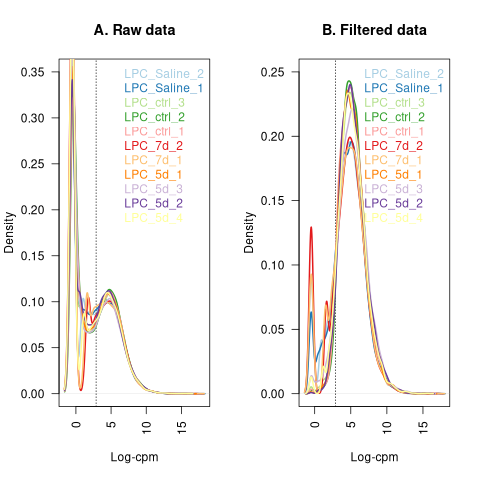

In [23]:
%%R
lcpm.cutoff <- log2(10/M + 2/L)
library(RColorBrewer)
nsamples <- ncol(x2)
col <- brewer.pal(nsamples, "Paired")

par(mfrow=c(1,2))

lcpm <- edgeR::cpm(x, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.35), las=2, main="", xlab="")
title(main="A. Raw data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

lcpm <- edgeR::cpm(x2, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.25), las=2, main="", xlab="")
title(main="B. Filtered data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

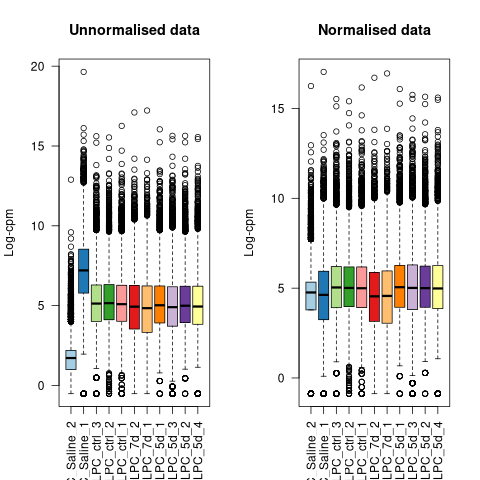

In [24]:
%%R
y2 <- x2
y2$samples$norm.factors <- 1
y2$counts[,1] <- ceiling(y2$counts[,1]*0.05)
y2$counts[,2] <- y2$counts[,2]*5

par(mfrow=c(1,2))
lcpm <- edgeR::cpm(y2, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="Unnormalised data", ylab="Log-cpm")

y3 <- calcNormFactors(y2)
y3$samples$norm.factors

lcpm <- edgeR::cpm(y3, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="Normalised data", ylab="Log-cpm")

# Show how log transf + batch removal affects the separation of samples:

In [25]:
%%R
cd <- x2$samples$group
print(cd)

 [1] ctrl ctrl ctrl ctrl ctrl stim stim stim stim stim stim
Levels: ctrl stim


In [26]:
%%R
#Make new count matrix with log counts and DGE data from X2 (trimmed, normfactors)
x3 <- x2
x3$counts <- lcpm

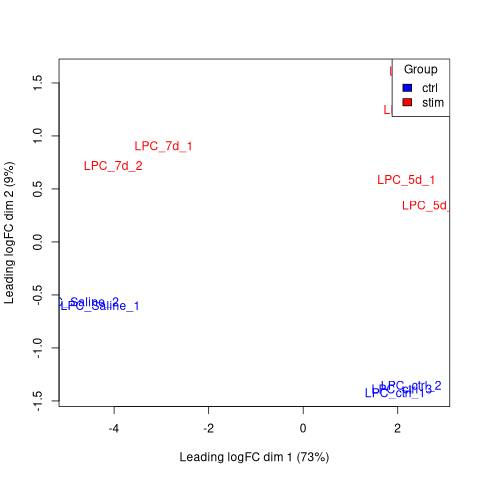

In [27]:
%%R
# Assuming 'group' is stored in y$samples dataframe
group <- x2$samples$group

# Generate a numeric vector from group factors (if not already factor, convert it)
group_factor <- as.factor(group)
group_colors <- as.numeric(group_factor)  # This converts factors to unique integers

# Define a set of colors corresponding to the factors
# Example: If you have two groups, you could define two colors
colors <- c("blue", "red")  # Adjust the number and colors based on your actual groups

# Use these colors in your plotMDS
plotMDS(x2, col = colors[group_colors])

# Adding a legend for clarity
legend("topright", legend=levels(group_factor), fill=colors, title="Group")

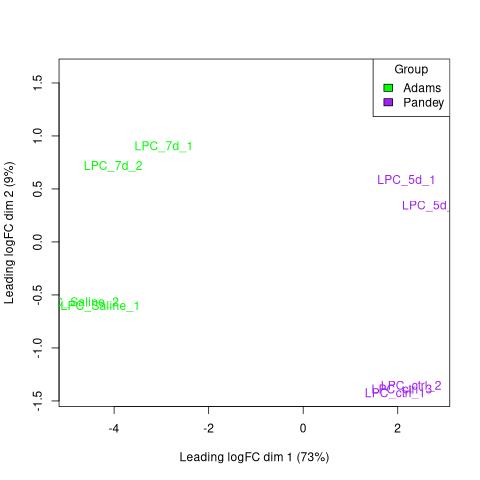

In [28]:
%%R
# Generate a numeric vector from group factors (if not already factor, convert it)
pub_factor <- as.factor(batch)
pub_colors <- as.numeric(pub_factor)  # This converts factors to unique integers

# Define a set of colors corresponding to the factors
# Example: If you have two groups, you could define two colors
colors <- c("green", "purple")  # Adjust the number and colors based on your actual groups

# Use these colors in your plotMDS
plotMDS(x2, col = colors[pub_colors])

# Adding a legend for clarity
legend("topright", legend=levels(pub_factor), fill=colors, title="Group")

In [29]:
%%R

x3$samples

             group lib.size norm.factors
LPC_Saline_2  ctrl   773423    1.1336899
LPC_Saline_1  ctrl  1563898    1.1094697
LPC_ctrl_3    ctrl  1429120    1.0064049
LPC_ctrl_2    ctrl 12928507    0.9980820
LPC_ctrl_1    ctrl  5932506    1.0036342
LPC_7d_2      stim   368127    1.1285329
LPC_7d_1      stim   429453    1.0962585
LPC_5d_1      stim  1950777    0.9394770
LPC_5d_3      stim  3954871    0.8128918
LPC_5d_2      stim  1509561    0.8955474
LPC_5d_4      stim   665554    0.9320542


In [30]:
%%R
# Adjust for batch-- ie publication in the model matrix
design <- model.matrix(~0 + cd)
design

   cdctrl cdstim
1       1      0
2       1      0
3       1      0
4       1      0
5       1      0
6       0      1
7       0      1
8       0      1
9       0      1
10      0      1
11      0      1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$cd
[1] "contr.treatment"



In [31]:
%%R
contr.matrix <- makeContrasts(cdstim - cdctrl, levels = colnames(design))
contr.matrix

        Contrasts
Levels   cdstim - cdctrl
  cdctrl              -1
  cdstim               1


In [32]:
%%R
# Convert to CPM and log2 transformation. 
logCPM <- edgeR::cpm(x2, log=TRUE, prior.count=3)

In [33]:
%%R
#Batch is set to the publication of origin to remove effects between sample origins
logCPM_no_batch <- removeBatchEffect(logCPM, batch=batch) 

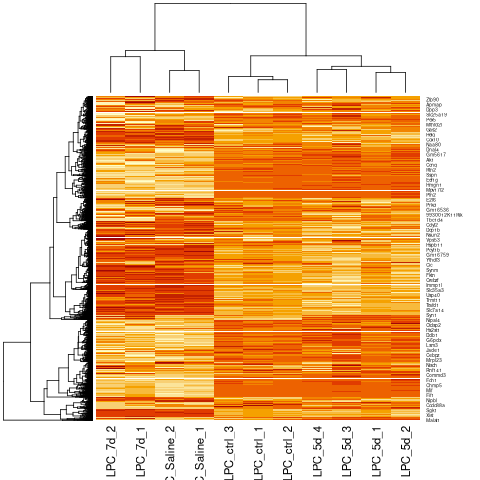

In [34]:
%%R
heatmap(logCPM)

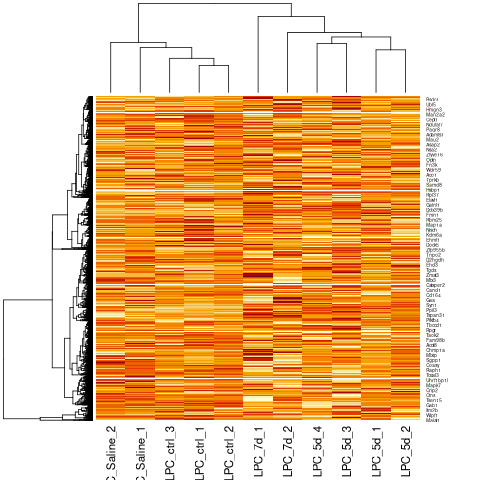

In [35]:
%%R
heatmap(logCPM_no_batch)

# Voom with quality weights

In [37]:
%%R
contr.matrix <- makeContrasts(cdstim - cdctrl, levels = colnames(design))
contr.matrix

        Contrasts
Levels   cdstim - cdctrl
  cdctrl              -1
  cdstim               1


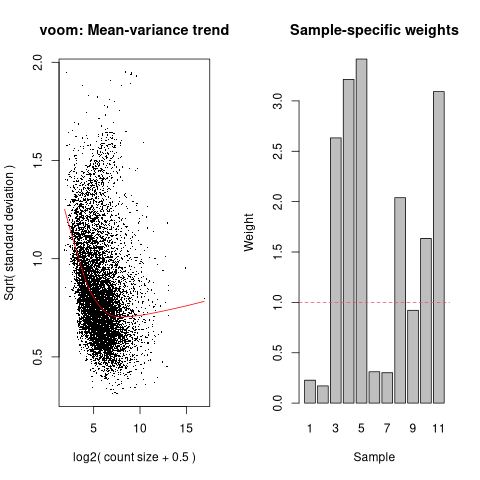

In [38]:
%%R
y <- voomWithQualityWeights(x2$counts, design, plot=TRUE)

In [39]:
%%R
corfit <- duplicateCorrelation(y, design, block=batch)
corfit$consensus.correlation

[1] 0.5361069


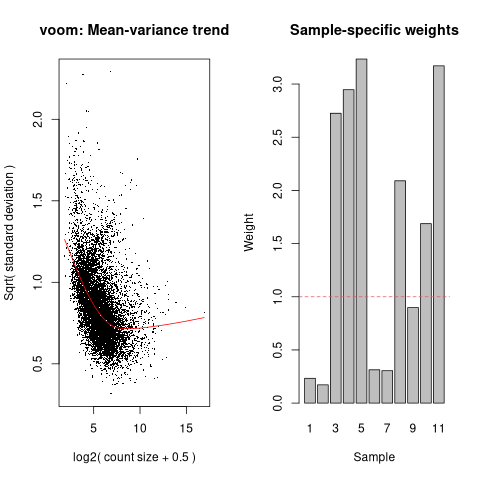

In [40]:
%%R
y2 <- voomWithQualityWeights(x2$counts, design, plot=TRUE, block=batch, correlation=corfit$consensus)

In [41]:
%%R
corfit2 <- duplicateCorrelation(y2,design, block=batch, weights=y2$targets$sample.weights)
corfit2$consensus.correlation

[1] 0.6229707


In [42]:
%%R
fit <- lmFit(y2, design, block=batch, correlation=corfit2$consensus)

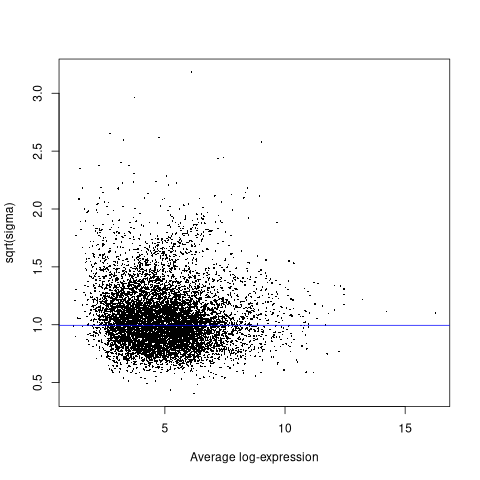

In [43]:
%%R
contr <- makeContrasts(cdstim - cdctrl, levels = colnames(coef(fit)))
tmp <- contrasts.fit(fit, contr)
tmp2 <- eBayes(tmp)

plotSA(tmp2, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [44]:
%%R
# Retrieve the top results without sorting by p-value directly
tt <- topTable(tmp2, sort.by = "P", n = Inf)
head(tt, 10)

           logFC  AveExpr        t      P.Value    adj.P.Val        B
C4b     4.702341 7.209963 33.74245 2.257351e-14 2.044709e-10 23.12898
Cachd1  4.205148 3.756685 30.59887 8.258574e-14 3.740308e-10 21.33383
Masp1   4.030808 5.957225 27.39822 3.560775e-13 1.075117e-09 20.55361
Ldlrap1 3.454752 5.218401 26.29356 6.128776e-13 1.387861e-09 20.02693
Tspan9  3.138013 5.899677 25.40807 9.625473e-13 1.743751e-09 19.61579
Pros1   3.982897 4.189096 22.67608 4.290371e-12 5.565829e-09 18.05726
Cntn3   2.938801 6.245241 22.67169 4.301259e-12 5.565829e-09 18.19949
Col16a1 3.565284 3.927703 19.55137 2.972148e-11 3.084814e-08 16.13592
Lhfpl3  3.878608 5.355775 19.50512 3.065061e-11 3.084814e-08 16.27620
Cebpd   3.396479 4.793640 19.13333 3.935500e-11 3.297349e-08 16.02526


In [45]:
%%R
length(which(tt$adj.P.Val < 0.05))

[1] 1278


In [48]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
significant_genes <- tt[tt$adj.P.Val < 0.05 & abs(tt$logFC) > 0.7, ]
num_significant_genes <- nrow(significant_genes)

# Print the number of significant genes
print(num_significant_genes)

[1] 911


In [46]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
significant_genes <- tt[tt$adj.P.Val < 0.05 & abs(tt$logFC) > 1, ]
num_significant_genes <- nrow(significant_genes)

# Print the number of significant genes
print(num_significant_genes)

[1] 566


In [47]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt[tt$adj.P.Val < 0.05 & tt$logFC > 1, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 334
                  logFC  AveExpr         t      P.Value    adj.P.Val         B
Klk6          11.318240 4.362265  7.788638 2.442276e-06 1.286171e-04  5.074306
Klk8          10.662749 2.280268  7.548343 3.456891e-06 1.779121e-04  4.732634
Bcan           8.911674 1.641114 12.311777 1.076928e-08 1.990778e-06  9.693316
Serpina3n      8.764836 5.881914 19.107802 4.004287e-11 3.297349e-08 15.720323
2310002F09Rik  8.453252 2.527361 12.088867 1.350407e-08 2.398429e-06  9.462601
Steap3         8.167608 2.415217 13.540118 3.284279e-09 8.405410e-07 10.558919


In [49]:
%%R
if ('C4b' %in% rownames(genes_up_sorted)) {
    print("C4b is in the index of genes_up_sorted")
} else {
   print("C4b is not in the index of genes_up_sorted")
}

[1] "C4b is in the index of genes_up_sorted"


In [50]:
%%R
if ('Serpina3n' %in% rownames(genes_up_sorted)) {
    print("Serpina3n is in the index of genes_up_sorted")
} else {
    print("Serpina3n is not in the index of genes_up_sorted")
}

[1] "Serpina3n is in the index of genes_up_sorted"


In [51]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt[tt$adj.P.Val < 0.05 & tt$logFC < -1, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 232
           logFC  AveExpr         t      P.Value    adj.P.Val          B
Lcp1   -4.856646 1.858818 -7.169795 6.064477e-06 0.0002831548  4.1064042
Arl4d  -4.395685 3.479439 -5.469172 9.599636e-05 0.0022182015  1.6274404
Ptprj  -4.332866 4.716590 -4.753285 3.456403e-04 0.0059121446  0.4448447
Hivep2 -4.105300 5.192170 -5.210117 1.514130e-04 0.0030889621  1.2058310
Tgfbr1 -3.998339 2.707848 -3.409395 4.466960e-03 0.0371208465 -1.9387638
Irak2  -3.950374 1.197683 -7.076480 6.985530e-06 0.0003154106  4.0241761


In [52]:
%%R
head(tt)

           logFC  AveExpr        t      P.Value    adj.P.Val        B
C4b     4.702341 7.209963 33.74245 2.257351e-14 2.044709e-10 23.12898
Cachd1  4.205148 3.756685 30.59887 8.258574e-14 3.740308e-10 21.33383
Masp1   4.030808 5.957225 27.39822 3.560775e-13 1.075117e-09 20.55361
Ldlrap1 3.454752 5.218401 26.29356 6.128776e-13 1.387861e-09 20.02693
Tspan9  3.138013 5.899677 25.40807 9.625473e-13 1.743751e-09 19.61579
Pros1   3.982897 4.189096 22.67608 4.290371e-12 5.565829e-09 18.05726


# Save output- make sure to rename!

In [53]:
%%R
# Add rownames as a proper column, but ensure we do not have duplicates
tt$gene <- rownames(tt)

# Remove rownames to avoid duplication when saving
rownames(tt) <- NULL

# Write to CSV file
write.table(tt, file = "./files/LPC_demyel_MOL_BvE_voom_wqw_REDO.csv", 
            row.names = FALSE, sep = ",", quote = FALSE)

# Check the first few rows to confirm the structure
head(tt)

     logFC  AveExpr        t      P.Value    adj.P.Val        B    gene
1 4.702341 7.209963 33.74245 2.257351e-14 2.044709e-10 23.12898     C4b
2 4.205148 3.756685 30.59887 8.258574e-14 3.740308e-10 21.33383  Cachd1
3 4.030808 5.957225 27.39822 3.560775e-13 1.075117e-09 20.55361   Masp1
4 3.454752 5.218401 26.29356 6.128776e-13 1.387861e-09 20.02693 Ldlrap1
5 3.138013 5.899677 25.40807 9.625473e-13 1.743751e-09 19.61579  Tspan9
6 3.982897 4.189096 22.67608 4.290371e-12 5.565829e-09 18.05726   Pros1


# Do results overlap with LR pairs?

In [54]:
import liana as li

In [55]:
lr_pairs = li.resource.select_resource('mouseconsensus')
lr_pairs.head()

,ligand,receptor
31371,Dll1,Notch1
31372,Dll1,Notch2
31373,Dll1,Notch4
31374,Dll1,Notch3
31375,Nrg2,Erbb2_Erbb3


In [56]:
DEG_all = pd.read_csv('./files/LPC_demyel_MOL_BvE_voom_wqw_REDO.csv', index_col=None)
DEG_all.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
DEG_all.rename(columns={'P.Value': 'Pvalue'}, inplace=True)
DEG_all.shape

(9058, 7)

In [57]:
sigs = DEG_all[(DEG_all.Padj < 0.05) & (abs(DEG_all.logFC) >= 1)]
sigs.shape

(566, 7)

In [58]:
lr_pairs.shape

(3989, 2)

In [59]:
sigs.head()

,logFC,AveExpr,t,Pvalue,Padj,B,gene
0,4.702341,7.209963,33.742453,2.257351e-14,2.044709e-10,23.128980,C4b
1,4.205148,3.756685,30.598865,8.258574e-14,3.740308e-10,21.333826,Cachd1
2,4.030808,5.957225,27.398217,3.560775e-13,1.075117e-09,20.553614,Masp1
3,3.454752,5.218401,26.293565,6.128776e-13,1.387861e-09,20.026931,Ldlrap1
4,3.138013,5.899677,25.408068,9.625473e-13,1.743751e-09,19.615787,Tspan9


In [60]:
ligands = lr_pairs['ligand'].unique()
receptors = lr_pairs['receptor'].unique()

# Combining both ligands and receptors and keeping only unique values
unique_genes = set(ligands).union(set(receptors))

# Checking for overlap with 'sigs' dataframe on the 'gene' column
overlap_genes = sigs[sigs['gene'].isin(unique_genes)]
overlap_genes

,logFC,AveExpr,t,Pvalue,Padj,B,gene
0,4.702341,7.209963,33.742453,2.257351e-14,2.044709e-10,23.128980,C4b
5,3.982897,4.189096,22.676075,4.290371e-12,5.565829e-09,18.057256,Pros1
6,2.938801,6.245241,22.671690,4.301259e-12,5.565829e-09,18.199485,Cntn3
7,3.565284,3.927703,19.551373,2.972148e-11,3.084814e-08,16.135917,Col16a1
11,3.711783,3.716997,18.956607,4.439086e-11,3.350770e-08,15.831551,Nrtn
...,...,...,...,...,...,...,...
1007,-1.016486,7.000101,-3.536311,3.488209e-03,3.134543e-02,-2.612287,Lama2
1089,-3.998339,2.707848,-3.409395,4.466960e-03,3.712085e-02,-1.938764,Tgfbr1
1129,1.126038,2.928660,3.359985,4.919045e-03,3.940186e-02,-2.479454,Fgf22
1153,-1.042999,2.984559,-3.323925,5.277758e-03,4.142629e-02,-2.439959,Dag1


In [61]:
# Checking the direction of logFC for the overlapping genes
overlap_genes_direction = overlap_genes[['gene', 'logFC']].copy()

# Determine the direction of logFC
overlap_genes_direction['logFC_direction'] = overlap_genes_direction['logFC'].apply(lambda x: 'positive' if x > 0 else 'negative')

# Displaying the results
overlap_genes_direction

,gene,logFC,logFC_direction
0,C4b,4.702341,positive
5,Pros1,3.982897,positive
6,Cntn3,2.938801,positive
7,Col16a1,3.565284,positive
11,Nrtn,3.711783,positive
...,...,...,...
1007,Lama2,-1.016486,negative
1089,Tgfbr1,-3.998339,negative
1129,Fgf22,1.126038,positive
1153,Dag1,-1.042999,negative


In [62]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 8


,ligand,receptor,logFC_ligand,logFC_receptor
3,Bcan,Nrcam,8.911674,8.142582
6,Sema4f,Nrp2,6.739026,-3.281985
7,Sparc,Fgfr1,2.623311,2.941145
2,Apoe,Scarb1,1.433722,-3.431736
5,Fgf22,Fgfrl1,1.126038,7.256179
4,Fgf22,Fgfr1,1.126038,2.941145
1,Lama2,Dag1,-1.016486,-1.042999
0,Alcam,Chl1,-1.975366,7.769540


In [63]:
sigs_up = DEG_all[(DEG_all.Padj < 0.05) & (DEG_all.logFC >= 1)]
sigs_up.shape

(334, 7)

In [64]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs_up['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 4


,ligand,receptor,logFC_ligand,logFC_receptor
0,Bcan,Nrcam,8.911674,8.142582
3,Sparc,Fgfr1,2.623311,2.941145
1,Fgf22,Fgfr1,1.126038,2.941145
2,Fgf22,Fgfrl1,1.126038,7.256179


In [ ]:
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']].to_csv('./files/LR_LPC_demyel_MOL_BvE.csv', sep='\t', index=False)